In [1]:
import torch
import torch.nn as nn

import torch.utils.data
from torch.utils.data.dataloader import DataLoader

import torchvision
import torchsummary

import matplotlib.pyplot as plt
import ipywidgets

from fastprogress.fastprogress import master_bar, progress_bar

import sys
import os
from pathlib import Path

In [2]:
batch_size = 64
number_of_layers = 4
latent_space_size = 2
epochs = 40
learning_rate = 0.001

# config = {
#     "batch_size": batch_size,
#     "number_of_layers": number_of_layers,
#     "latent_space_size": latent_space_size,
#     "epochs": epochs,
#     "learning_rate": learning_rate,
# }

# wandb.init(project="wiktor-vrije-learn.autoencoder.basic", config=config, save_code=False)

In [3]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

dataset = torchvision.datasets.MNIST("~/pytorch/data", train=True, transform=transforms)

In [4]:
train_data, validation_data, test_data = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])
validation_data_loader, test_data_loader = DataLoader(validation_data, batch_size), DataLoader(test_data, batch_size)

In [5]:
data_iter = iter(dataset)
data_x, data_y = next(data_iter)
print(torch.max(data_x), torch.min(data_x))

tensor(1.) tensor(0.)


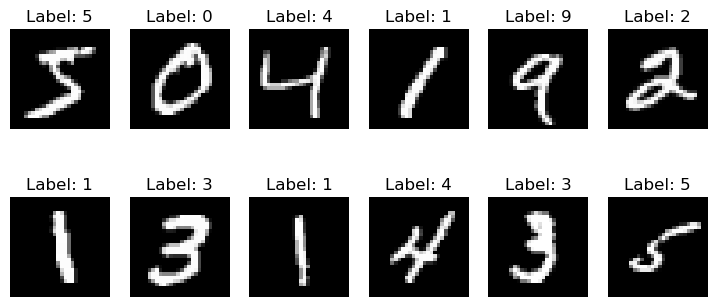

In [6]:
num_col = 6
num_row = 2
offset = 0

data_iter = iter(dataset)
for _ in range(offset):
    next(data_iter)


_, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i, ax in enumerate(axs.flatten()):
    data_x, data_y = next(data_iter)

    img = data_x.squeeze()
    ax.set_title(f"Label: {data_y}")
    ax.imshow(img, cmap="grey")
    ax.set_axis_off()

plt.show()

In [7]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent.joinpath("model")))

from MNISTAutoencoder import MNISTAutoencoder

In [8]:
model = MNISTAutoencoder(latent_space_size, number_of_layers)
# wandb.watch(model)

In [9]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent))

from train import train_model


print(f"Training model: {model}")
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

model.train()
train_model(model, learning_rate, epochs, train_data_loader)

model.eval()
0

Training model: MNISTAutoencoder:
    Latent size: 2, Layers count: 4


0

In [10]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent))

from evaluate import evaluate_model


validation_loss = evaluate_model(model, validation_data_loader)
test_loss = evaluate_model(model, test_data_loader)

print(f"Validation loss: {validation_loss}")
print(f"Test loss: {test_loss}")
print(f"For model {model}")
print()

Validation loss: 0.03708719089627266
Test loss: 0.03742927312850952
For model MNISTAutoencoder:
    Latent size: 2, Layers count: 4



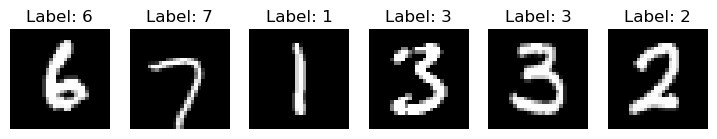

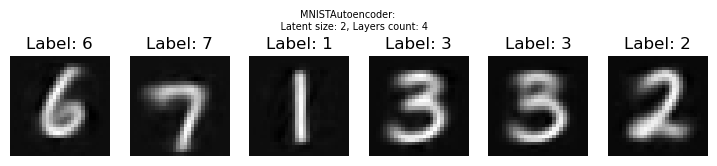

In [11]:
from random import randint

data_iter = iter(test_data_loader)
offset = randint(0, 10)
num_col = 6
num_row = 1

for _ in range(offset):
    next(data_iter)
data_x, data_y = next(data_iter)


def plot_images(data_x, title=None):
    fig, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    if title:
        fig.suptitle(title, fontsize=7)

    for i, ax in enumerate(axs.flatten()):
        img = data_x[i].squeeze()
        ax.set_title(f"Label: {data_y[i]}")

        ax.imshow(img, cmap="grey")
        ax.set_axis_off()

    plt.show()


plot_images(data_x)
plot_images(model(data_x).detach().numpy(), str(model))

This is the place where you can play with the model!

In [12]:
# We used the sigmoid function, so the repr in the latent space is between 0 and 1.
eir = latent_space_ipywidgets_range = (0, 1, 0.001)


def play_with_model(model: MNISTAutoencoder):
    latent_space_params_dict = {}
    for i in range(model.latent_space_size):
        latent_space_params_dict[f"P{i+1}"] = eir

    def update(**kwargs):
        latent_space_array = list(kwargs.values())
        encoded = torch.tensor(latent_space_array).reshape(1, model.latent_space_size)
        decoded_image = model.decoder(encoded)
        plt.imshow(decoded_image.detach().numpy()[0][0], cmap="grey")

    ipywidgets.interact(update, **latent_space_params_dict)


play_with_model(model)

interactive(children=(FloatSlider(value=0.0, description='P1', max=1.0, step=0.001), FloatSlider(value=0.0, de…